# Supplemental Figure S9: Quantitative analysis of DMS reactivity in WC and non-WC nucleotides  

# Setup

## imports

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.linear_model import LogisticRegression

from dms_3d_features.plotting import *

## extra functions

## load data

In [3]:
DATA_PATH = "../../data"
REVISION_PATH = "../../data/revisions"

In [5]:
df_res = pd.read_json(f"{DATA_PATH}/raw-jsons/residues/pdb_library_1_residues.json")
df_res["r_type_simple"] = df_res["r_type"].replace("Flank-WC", "WC")

# Plotting

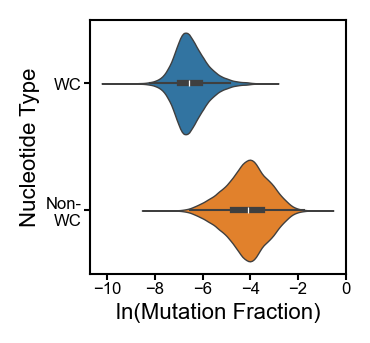

In [14]:
def plot_figure_s8a(df, ax):
    ax = sns.violinplot(
        x="ln_r_data",
        y="r_type_simple",
        data=df,
        hue="r_type_simple",
        order=["WC", "NON-WC"],
        ax=ax,
        linewidth=0.5,
    )
    ax.set_xlabel("ln(Mutation Fraction)", labelpad=2)
    ax.set_ylabel("Nucleotide Type", labelpad=2)
    ax.yaxis.set_major_locator(FixedLocator([0, 1, 2]))
    ax.yaxis.set_major_formatter(FixedFormatter(["WC", "Non-\nWC"]))
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8a(df_res, ax);


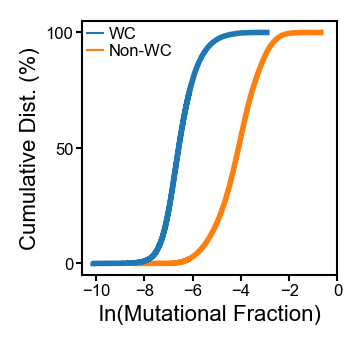

In [13]:
def plot_figure_s8b(df, ax):
    df.sort_values("r_type", inplace=True, ascending=True)
    colors = {"WC": "tab:blue", "NON-WC": "tab:orange"}
    # Loop through each unique r_type to plot the cumulative distribution
    for r_type, group_data in df.groupby("r_type_simple"):
        sorted_data = np.sort(group_data["ln_r_data"])
        cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
        ax.plot(sorted_data, cdf, label=r_type, lw=2, color=colors[r_type])
    ax.set_ylabel("Cumulative Dist. (%)", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    add_legend(ax, ["WC", "Non-WC"], loc="upper left")
    publication_style_ax(ax)
    return ax


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8b(df_res, ax);

In [17]:
df_res["ln_r_data"].replace(-np.inf, -10, inplace=True)
# Convert 'r_type' to binary (1 for 'WC', 0 for 'NON-WC')
df_res["r_type_binary"] = df_res["r_type_simple"].apply(lambda x: 1 if x == "WC" else 0)
# Fit the logistic regression model
model = LogisticRegression()
model.fit(df_res[["ln_r_data"]], df_res["r_type_binary"])
# Compute probabilities for the original data
df_res["prob_WC"] = model.predict_proba(df_res[["ln_r_data"]])[:, 1]
# Display the probabilities
df_res.sort_values("prob_WC", ascending=False)[["ln_r_data", "r_type_simple", "prob_WC"]]

,ln_r_data,r_type_simple,prob_WC
159066,-10.126631,WC,1.000000
158030,-10.126631,WC,1.000000
159518,-9.903488,WC,0.999999
170993,-9.903488,WC,0.999999
330548,-9.903488,WC,0.999999
...,...,...,...
463233,-1.013022,NON-WC,0.000006
463209,-0.994414,NON-WC,0.000005
105290,-0.972755,NON-WC,0.000005
105296,-0.853363,NON-WC,0.000004


In [19]:
# Calculate the absolute difference between each value in the column 'prob_WC' and 0.5
df_res["abs_diff"] = (df_res["prob_WC"] - 0.50).abs()

# Find the index of the minimum difference
min_index = df_res["abs_diff"].idxmin()

# Retrieve the entire row that is closest to 0.5 in the 'prob_WC' column
closest_row = df_res.loc[min_index]

print("The row with the value in 'prob_WC' closest to 0.5 is:")
print(closest_row["ln_r_data"])

The row with the value in 'prob_WC' closest to 0.5 is:
-5.1379006451


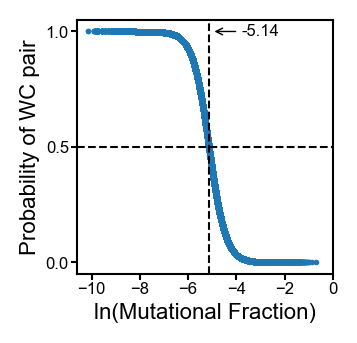

In [20]:
def plot_figure_s8c(df, ax):
    ax.scatter(df["ln_r_data"], df["prob_WC"], s=1)
    ax.set_ylabel("Probability of WC pair", labelpad=2)
    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])

    # reference lines
    ax.axhline(y=0.5, color="black", linestyle="--", lw=0.75)
    ax.axvline(x=-5.14, color="black", linestyle="--", lw=0.75)

    # Move text and arrow up further, make arrow longer, move text back
    text_y = 1.0
    arrow_y = 1.0
    arrow_tip_x = -5.14
    arrow_start_x = -3.8  # make arrow longer
    text_x = -3.8  # move text back

    # text label (no arrow)
    ax.text(
        text_x, text_y, "-5.14", fontsize=6, fontname="Arial", ha="left", va="center"
    )
    # separate arrow, perfectly horizontal, longer and higher
    ax.annotate(
        "",
        xy=(arrow_tip_x, arrow_y),  # arrow tip on the line
        xytext=(arrow_start_x, arrow_y),  # start point of arrow (same y, further x)
        arrowprops=dict(arrowstyle="->", lw=0.5, color="black", mutation_scale=6),
    )
    publication_style_ax(ax)


fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8c(df_res, ax)

<Axes: xlabel='ln(Mutational Fraction)', ylabel='Count (×10³)'>

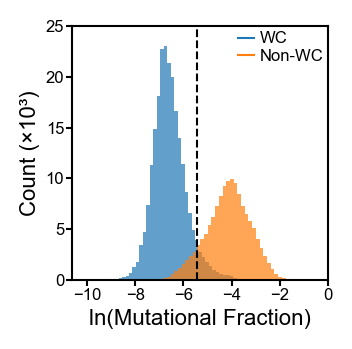

In [22]:
def plot_figure_s8d(df, ax, threshold=-5.45):
    # Plot histogram with two colors
    ax.hist(
        df.query("r_type == 'WC'")["ln_r_data"],
        bins=50,
        color="tab:blue",
        alpha=0.7,
    )
    ax.hist(
        df.query("r_type == 'NON-WC'")["ln_r_data"],
        bins=50,
        color="tab:orange",
        alpha=0.7,
    )
    # Add vertical line at threshold
    ax.axvline(x=threshold, color="black", linestyle="--", linewidth=0.75)

    ax.set_xlabel("ln(Mutational Fraction)", labelpad=2)
    ax.set_ylabel("Count (×10³)", labelpad=2)
    ax.set_xticks([-10, -8, -6, -4, -2, 0])
    ax.set_yticks(
        [0, 5000, 10000, 15000, 20000, 25000], labels=["0", "5", "10", "15", "20", "25"]
    )
    add_legend(ax, ["WC", "Non-WC"], loc="upper right")
    publication_style_ax(ax)
    return ax


# Create and save plot
fig, ax = plt.subplots(figsize=(1.65, 1.65), dpi=200)
plot_figure_s8d(df_res, ax)

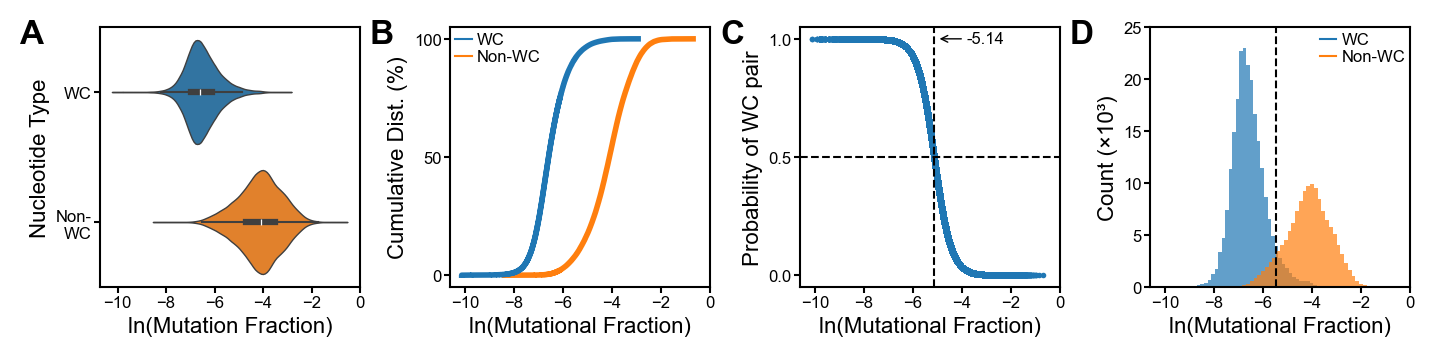

In [23]:
fig_size = (7, 2)
layout = (1, 4)
subplot_size = (1.3, 1.3)  # Each subplot is 4" x 3"
spacing = {
    "hspace": 0.45,  # horizontal spacing in inches
    "wspace": 0.50,  # vertical spacing in inches
    "margins": {"left": 0.40, "right": 0.0, "top": 0.0, "bottom": 0.50},
}

coords_list = calculate_subplot_coordinates(fig_size, layout, subplot_size, spacing)
fig = plt.figure(figsize=fig_size, dpi=200)

ax1 = fig.add_axes(coords_list[0])
plot_figure_s8a(df_res, ax1)

ax2 = fig.add_axes(coords_list[1])
plot_figure_s8b(df_res, ax2)

ax3 = fig.add_axes(coords_list[2])
plot_figure_s8c(df_res, ax3)

ax4 = fig.add_axes(coords_list[3])
plot_figure_s8d(df_res, ax4)
add_subplot_labels(fig, coords_list)
fig.savefig(
    "../../figures/supplemental_figures/supplemental_figure_s8.png",
    dpi=600,
    bbox_inches="tight",
)